# LSTM

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Load datasets
train_data = pd.read_csv('sales_train_validation_afcs2024.csv')
test_validation_data = pd.read_csv('sales_test_validation_afcs2024.csv')
test_evaluation_data = pd.read_csv('sales_test_evaluation_afcs_2024.csv')
submission_template = pd.read_csv('sample_submission_afcs2024.csv')


In [30]:

# Step 1: Combine Training and Validation Data
train_data_combined = pd.concat([train_data, test_validation_data.drop(columns=["id"])], axis=1)

# Step 2: Separate Evaluation Data
test_evaluation_ids = test_evaluation_data['id']
test_evaluation_sales = test_evaluation_data.drop(columns=["id"]).values

# Step 3: Define Dataset Class
class WideTimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=28):
        self.data = data.iloc[:, 1:].values  # Exclude 'id' column
        self.sequence_length = sequence_length

    def __len__(self):
        return (self.data.shape[1] - self.sequence_length) * self.data.shape[0]

    def __getitem__(self, idx):
        row = idx // (self.data.shape[1] - self.sequence_length)
        start_col = idx % (self.data.shape[1] - self.sequence_length)
        series = self.data[row, start_col:start_col + self.sequence_length + 1]

        X = series[:-1].reshape(-1, 1)  # Input sequence
        y = series[-1]  # Target value
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Step 4: Create Datasets and DataLoaders
sequence_length = 28
dataset = WideTimeSeriesDataset(train_data_combined, sequence_length)

# Train-Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [31]:

# Step 5: Define the LSTM Model
class GlobalLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, dropout=0.2):
        super(GlobalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

# Initialize Model
model = GlobalLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 6: Train the Model
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch 1/25, Train Loss: 9.5887, Val Loss: 8.9450
Epoch 2/25, Train Loss: 8.7604, Val Loss: 9.0098
Epoch 3/25, Train Loss: 8.6551, Val Loss: 8.8216
Epoch 4/25, Train Loss: 8.6456, Val Loss: 8.9248
Epoch 5/25, Train Loss: 8.5957, Val Loss: 9.1371
Epoch 6/25, Train Loss: 8.6387, Val Loss: 9.7184
Epoch 7/25, Train Loss: 8.6288, Val Loss: 9.0748
Epoch 8/25, Train Loss: 8.6372, Val Loss: 8.9378
Epoch 9/25, Train Loss: 8.5850, Val Loss: 9.0921
Epoch 10/25, Train Loss: 8.6085, Val Loss: 9.3301
Epoch 11/25, Train Loss: 8.6068, Val Loss: 9.1011
Epoch 12/25, Train Loss: 8.5461, Val Loss: 9.1404
Epoch 13/25, Train Loss: 8.6389, Val Loss: 8.9928
Epoch 14/25, Train Loss: 8.5855, Val Loss: 9.3688
Epoch 15/25, Train Loss: 8.6791, Val Loss: 8.9553
Epoch 16/25, Train Loss: 8.6112, Val Loss: 8.8095
Epoch 17/25, Train Loss: 8.6015, Val Loss: 8.8300
Epoch 18/25, Train Loss: 8.6136, Val Loss: 9.2520
Epoch 19/25, Train Loss: 8.6843, Val Loss: 9.1663


KeyboardInterrupt: 

In [ ]:
# Step 7: Rolling Forecast for Test Evaluation
def rolling_forecast(model, initial_series, steps, sequence_length, device):
    model.eval()
    forecasts = []
    current_sequence = np.array(initial_series[-sequence_length:], dtype=np.float32).reshape(-1, 1)

    with torch.no_grad():
        for _ in range(steps):
            input_tensor = torch.tensor(current_sequence, dtype=torch.float32).unsqueeze(0).to(device)
            prediction = model(input_tensor).cpu().numpy().squeeze()
            forecasts.append(prediction)
            current_sequence = np.append(current_sequence[1:], prediction).reshape(-1, 1)
    return forecasts


# Generate Predictions for Each Series in Test Evaluation
all_predictions = []
for i in range(len(test_evaluation_sales)):
    initial_series = train_data_combined.iloc[i, -28:].values  # Use last 28 days from training + validation data
    forecast = rolling_forecast(model, initial_series, steps=28, sequence_length=28, device=device)
    all_predictions.append(forecast)

# Step 8: Prepare Submission File
predictions_df = pd.DataFrame(all_predictions, columns=[f"d_{1942 + i}" for i in range(28)])
predictions_df.insert(0, "id", test_evaluation_ids)
predictions_df.to_csv("test_evaluation_forecasts.csv", index=False)


In [ ]:
import matplotlib.pyplot as plt

def plot_forecast(series_id, actual_series, forecast_series, actual_future_series, start_date, forecast_start_date, steps=28):
    """
    Plot actual historical sales, actual future sales, and forecasted sales for the last year.

    Args:
        series_id (str): The identifier for the time series (e.g., product/store ID).
        actual_series (array-like): Historical sales data.
        forecast_series (array-like): Forecasted sales data.
        actual_future_series (array-like): Actual sales for the forecasted period.
        start_date (str): Start date of the historical data.
        forecast_start_date (str): Start date of the forecast period.
        steps (int): Number of forecast steps.
    """
    # Create date ranges for plotting
    actual_dates = pd.date_range(start=start_date, periods=len(actual_series))
    forecast_dates = pd.date_range(start=forecast_start_date, periods=steps)

    # Focus on the last year of data (last 365 days)
    zoom_start_date = pd.Timestamp(forecast_start_date) - pd.Timedelta(days=365)
    zoom_end_date = pd.Timestamp(forecast_start_date) + pd.Timedelta(days=steps)

    # Filter dates and values for the last year
    actual_dates_zoom = actual_dates[actual_dates >= zoom_start_date]
    actual_values_zoom = actual_series[len(actual_series) - len(actual_dates_zoom):]

    # Plot the historical actual sales for the last year
    plt.figure(figsize=(12, 6))
    plt.plot(actual_dates_zoom, actual_values_zoom, label="Historical Sales", linewidth=2, color="blue")

    # Plot the forecasted sales with transparency
    plt.plot(forecast_dates, forecast_series, label="Forecasted Sales", linewidth=2, linestyle='--', color='orange')

    # Plot the actual sales for the forecasted period with slight transparency
    plt.plot(forecast_dates, actual_future_series, label="Actual Sales (Future)", linewidth=2, linestyle='-', color='green', alpha=0.6)

    # Add vertical line to mark the start of the forecast
    plt.axvline(x=forecast_dates[0], color='gray', linestyle='--', label="Forecast Start")

    # Add labels, title, legend, and grid
    plt.title(f"Sales Forecast for {series_id} (Last Year)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


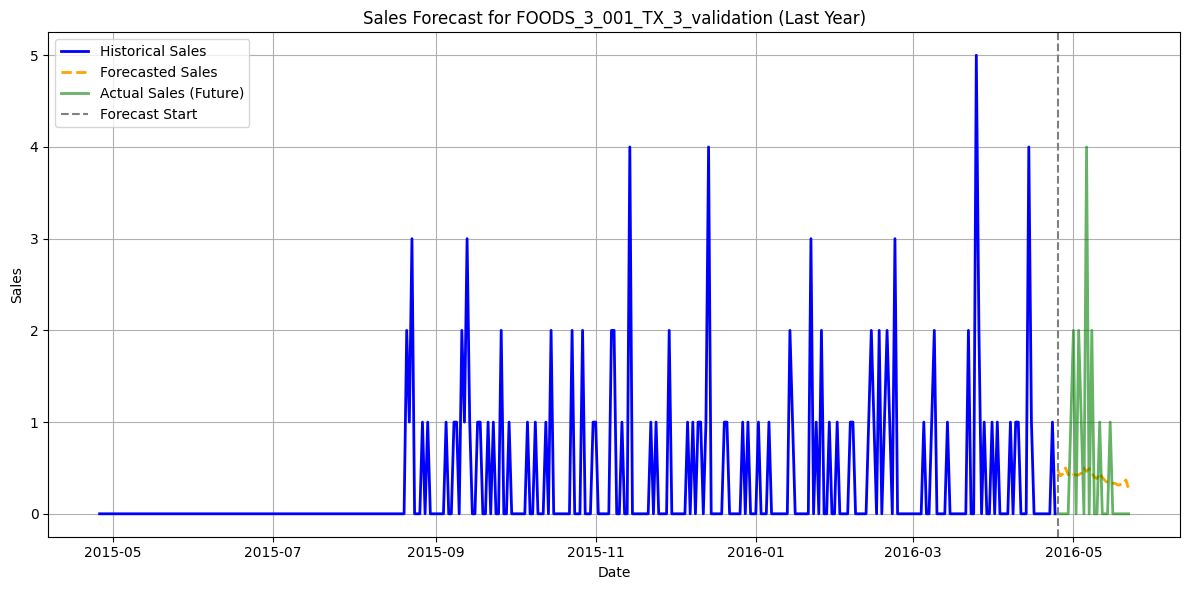

In [ ]:
# Example: Plot the forecast for the first series
series_id = test_evaluation_ids.iloc[0]
actual_series = train_data_combined.iloc[0, -1913:].values  # Full historical series
forecast_series = all_predictions[0]  # Forecasted values
actual_future_series = test_evaluation_sales[0]  # Actual sales for the forecast period
start_date = "2011-01-29"  # Start date of the dataset
forecast_start_date = "2016-04-25"  # Start of the forecast

# Plot the zoomed-in forecast
plot_forecast(series_id, actual_series, forecast_series, actual_future_series, start_date, forecast_start_date)


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(actual, predicted):
    """
    Calculate Root Mean Squared Error (RMSE).

    Args:
        actual (array-like): Ground truth values.
        predicted (array-like): Predicted values.

    Returns:
        float: RMSE score.
    """
    return np.sqrt(mean_squared_error(actual, predicted))


In [ ]:
# Initialize list to store RMSE values for each series
rmse_scores = []

# Calculate RMSE for each series
for i in range(len(test_evaluation_sales)):
    actual = test_evaluation_sales[i, :]  # Ground truth for the series
    predicted = all_predictions[i]       # Forecasted sales for the series
    rmse = calculate_rmse(actual, predicted)
    rmse_scores.append(rmse)

# Report overall RMSE
overall_rmse = np.mean(rmse_scores)
print(f"Overall RMSE: {overall_rmse:.4f}")


Overall RMSE: 2.0836


--------------------------------------------